<a href="https://colab.research.google.com/github/olsem1/WP-3/blob/master/KFold_%22LM%2C_Ridge%2C_DT%2C_RF%2C_XGB%2Bneer_cpi_2002_2019%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [481]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


In [482]:
course = pd.read_excel('RC_2002-2020.xlsx')
course = course.rename(columns={"data": "date"})
course = course.set_index('date')
course_m = course.resample('MS').mean()

# **Переменные**

In [483]:
cpi = "year"
reg_names = ['RF']
data_do = "2019-12-01"
train_do = "2019-09-01"

In [484]:
data = pd.read_excel('cpi_reg.xls', sheet_name = cpi)
data = data.set_index('date')
data = data.interpolate(method='polynomial', order=2, axis=0)
data.isna().sum().sum()

0

In [485]:
data.tail(12)

,RF,BEL,BRY,VLA,VOR,IVA,KAL,KOS,KUR,LIP,MOS,ORL,RYA,SMO,TAM,TVE,TUL,YAR,MOW,KAR,KOM,ARK,VLG,KAG,LEN,MUR,NGR,PSK,SPB,ADY,KLM,KRA,AST,VGG,ROS,DAG,ING,KAB,KAO,NOR,STA,BAS,MAR,MOR,TAT,UDM,CHV,PER,KIR,NIZ,ORE,PNZ,SAM,SAR,ULY,KUG,SVE,TYU,CHE,ALI,TUV,KHK,ALT,KYA,IRK,KEM,NVS,OMS,TOM,BUR,ZAB,SAH,KAM,PRI,KHA,AMU,MAG,SAK,JEW,CHU
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,103.40,102.67,103.38,103.09,103.36,103.60,102.96,104.14,104.06,103.48,103.71,103.47,102.94,102.29,104.30,102.94,102.47,104.32,103.85,103.34,103.61,103.17,103.04,103.35,103.13,103.98,103.26,102.37,103.12,101.94,104.04,103.09,103.09,102.65,102.91,103.98,103.79,104.17,102.46,102.77,103.70,103.41,103.36,102.26,102.99,102.57,102.47,103.30,102.72,103.41,103.17,102.73,103.35,102.92,103.20,104.22,103.42,102.22,103.33,101.30,103.18,103.83,103.29,103.49,104.30,103.68,102.69,103.57,103.65,104.56,104.11,103.24,103.78,102.97,103.80,105.08,102.37,103.92,105.24,105.06
2019-12-01,102.80,102.33,102.93,101.79,102.34,102.84,102.10,103.48,103.18,102.59,102.90,103.02,101.63,101.51,103.59,102.05,101.76,103.07,103.42,102.60,102.58,102.41,102.61,102.43,102.34,103.19,102.61,101.59,102.55,101.72,103.11,102.34,102.40,102.23,101.99,103.48,103.78,103.42,101.77,101.68,102.77,102.56,102.16,101.72,102.50,102.14,101.65,102.87,102.41,102.62,102.19,102.11,102.63,102.38,102.61,103.35,102.74,102.17,102.94,101.65,102.96,103.13,102.90,103.24,103.90,103.17,101.94,103.08,102.96,103.75,103.84,103.12,103.34,102.94,103.50,105.10,102.16,103.98,104.85,104.78
2020-01-01,102.29,101.66,101.85,101.70,101.84,102.32,101.36,103.08,102.75,102.29,102.13,102.04,101.50,100.93,102.77,101.43,101.06,102.49,102.81,102.16,102.06,102.00,102.26,101.89,102.06,102.88,102.30,101.03,101.95,101.76,102.53,101.86,101.83,101.59,101.68,103.33,103.75,103.01,101.57,101.50,102.32,101.93,101.78,101.12,101.97,101.61,101.58,102.21,102.68,102.41,101.73,101.47,101.89,101.81,101.93,102.81,101.88,101.77,102.59,101.88,102.73,102.61,102.32,102.72,103.79,101.96,101.75,102.40,102.51,103.76,103.65,102.68,103.00,102.89,103.54,105.12,102.10,104.13,104.96,103.42
2020-02-01,102.05,101.60,101.87,101.57,101.78,102.29,101.65,102.98,102.73,102.04,101.83,101.82,101.39,100.94,102.43,101.43,101.19,102.21,102.34,102.20,102.45,102.05,102.14,102.00,101.95,102.57,102.18,100.68,101.65,101.78,101.85,101.67,101.38,101.55,101.71,103.14,103.53,103.01,101.32,100.50,102.59,101.65,101.90,101.04,101.89,101.55,101.17,102.44,102.41,101.68,101.48,101.22,102.18,101.95,101.98,102.52,101.39,101.48,102.21,101.37,102.39,101.93,102.25,102.40,103.25,101.47,101.21,102.14,102.20,103.17,103.17,102.86,102.58,102.96,103.56,105.08,102.95,103.78,104.57,101.66
2020-03-01,102.39,101.86,102.67,102.04,102.58,103.08,101.98,103.60,102.86,102.21,101.90,102.45,101.95,101.61,102.73,101.90,102.08,103.11,102.36,102.63,102.51,102.38,103.07,102.40,102.32,102.96,102.81,101.48,102.23,101.85,102.39,101.96,101.91,102.19,101.87,103.34,103.14,103.25,102.00,101.18,102.93,102.49,102.20,101.79,101.96,102.07,101.49,102.65,103.06,102.37,101.92,102.13,102.28,102.70,102.40,102.96,101.94,101.85,102.87,101.27,102.93,102.13,102.56,102.39,103.34,101.94,101.73,102.42,102.19,103.24,103.74,102.80,102.09,102.64,103.35,105.09,103.65,103.84,104.76,101.05
2020-04-01,103.18,102.77,103.43,102.96,103.73,103.92,103.38,103.94,103.89,103.13,102.63,103.48,103.45,103.39,104.27,103.11,103.32,103.48,102.59,103.38,103.23,103.36,103.72,103.06,103.12,103.88,103.62,102.27,102.87,102.49,103.86,102.85,102.97,103.32,102.82,104.87,104.41,104.33,102.51,102.49,103.34,103.73,103.25,102.49,102.71,102.57,102.89,103.52,104.16,103.43,102.76,103.49,102.97,103.99,103.21,103.90,103.16,102.59,103.72,102.78,103.70,103.38,103.18,103.04,104.06,102.64,102.82,103.06,103.19,103.94,104.71,102.89,102.53,103.71,104.62,105.79,104.02,104.18,106.08,101.33
2020-05-01,103.07,102.95,103.74,102.52,103.67,103.54,103.51,103.79,103.66,103.14,102.80,103.49,103.61,102.99,103.82,103.11,103.24,103.68,102.65,103.46,103.25,103.36,103.

In [486]:
data = data[reg_names]
data = data[:data_do]
data = data.merge(course_m, left_on='date', right_on='date')

data['month'] = pd.DatetimeIndex(data.index).month

In [487]:
data

,RF,curs,month
date,,,
2002-01-01,115.34,30.472715,1
2002-02-01,114.07,30.805700,2
2002-03-01,112.89,31.064267,3
2002-04-01,112.09,31.173586,4
2002-05-01,112.16,31.254884,5
...,...,...,...
2019-08-01,104.31,65.587483,8
2019-09-01,104.03,64.958705,9
2019-10-01,103.76,64.374991,10


# **ARIMAX**

In [488]:
train = data[data.index < train_do]
test = data[data.index >= train_do]


In [489]:
!pip install pmdarima -q
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

In [490]:
exogenous_features = ['month', 'curs']


In [491]:
  # find best params for ARIMA
  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

"""  stepwise_model = auto_arima(train[reg_names], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True, \
                              d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, \
                              out_of_sample_size = test.shape[0], scoring = 'mse', information_criterion = 'oob')
  
stepwise_model = auto_arima(train_data['cpi_sfo'], start_p=1, start_q=1, max_p=3, max_q=3, m=1, start_P=0, seasonal=True,
                           d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
"""

stepwise_model.fit(train[reg_names])
future_forecast = stepwise_model.predict(n_periods=test.shape[0])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])


/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=347.114, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=478.952, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=360.560, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=369.753, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=477.987, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=349.016, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=348.838, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=347.545, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=349.720, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=347.584, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=345.538, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=368.535, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=358.899, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=347.448, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=347.2

rmse: 0.4520
normed rmse: 0.4367%


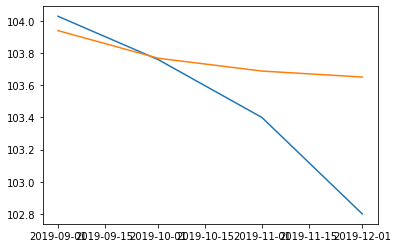

In [492]:
plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [493]:
result['ARIMAX']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMAX'])

In [494]:
# find best params for ARIMAX
stepwise_model = auto_arima(train[reg_names], exogenous = train[exogenous_features], start_p=1, start_q=1, 
                            max_p=4, max_q=4, m=12, start_P=0, seasonal=False,
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  
stepwise_model.fit(train[reg_names], exogenous = train[exogenous_features])
future_forecast = stepwise_model.predict(n_periods=test.shape[0], exogenous = test[exogenous_features])
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=[reg_names])

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=350.692, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=479.136, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=363.892, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=372.588, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=478.581, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=352.612, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=352.460, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=351.156, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=353.366, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=351.309, Time=0.82 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=349.151, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=371.505, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=362.272, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=351.078, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=350.9

rmse: 0.4206
normed rmse: 0.4064%


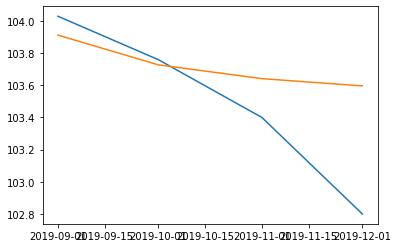

In [495]:
plt.plot(test[reg_names])
plt.plot(future_forecast[reg_names])

print('rmse: {:.4f}'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(test[reg_names].values, future_forecast[reg_names].values) ** 0.5 / 
                                    np.mean(test[reg_names].values) * 100))

In [496]:
result['ARIMA']=pd.DataFrame(np.array(future_forecast), index = test.index, columns=['ARIMA'])

In [497]:
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.34880,104.34880,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,104.46474,104.46474,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,104.61046,104.61046,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,104.47044,104.47044,104.47044,104.47044,103.275185


# **Feature Engineering**

In [498]:
data_lags = pd.DataFrame()

data_lags['curs'] = data['curs'].values
data_lags['t'] = data[reg_names].values
for i in {1, 6, 12}:
    data_lags['t-'+str(i)] = data[reg_names].shift(i).values
    
data_lags.index = data.index
data_lags = data_lags[12:]
data_lags['month'] = pd.DatetimeIndex(data_lags.index).month
data_lags

,curs,t,t-1,t-12,t-6,month
date,,,,,,
2003-01-01,31.816165,110.65,110.93,115.34,111.38,1
2003-02-01,31.698979,110.92,110.65,114.07,111.34,2
2003-03-01,31.453290,111.34,110.92,112.89,110.91,3
2003-04-01,31.211786,111.28,111.34,112.09,110.67,4
2003-05-01,30.907055,109.97,111.28,112.16,110.93,5
...,...,...,...,...,...,...
2019-08-01,65.587483,104.31,104.64,102.85,105.29,8
2019-09-01,64.958705,104.03,104.31,103.22,105.35,9
2019-10-01,64.374991,103.76,104.03,103.39,105.28,10


In [499]:
df=data_lags
df.reset_index(drop=False, inplace=True)
lag_features = ["t", "curs"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3m = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_6m = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_12m = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3m = df_rolled_3m.mean().shift(1).reset_index().astype(np.float32)
df_mean_6m = df_rolled_6m.mean().shift(1).reset_index().astype(np.float32)
df_mean_12m = df_rolled_12m.mean().shift(1).reset_index().astype(np.float32)

df_std_3m = df_rolled_3m.std().shift(1).reset_index().astype(np.float32)
df_std_6m = df_rolled_6m.std().shift(1).reset_index().astype(np.float32)
df_std_12m = df_rolled_12m.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3m[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_6m[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_12m[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3m[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_6m[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_12m[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("date", drop=True, inplace=True)
df.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,curs,t,t-1,t-12,t-6,month,t_mean_lag3,t_mean_lag6,t_mean_lag12,t_std_lag3,t_std_lag6,t_std_lag12,curs_mean_lag3,curs_mean_lag6,curs_mean_lag12,curs_std_lag3,curs_std_lag6,curs_std_lag12
date,,,,,,,,,,,,,,,,,,
2003-01-01,31.816165,110.65,110.93,115.34,111.38,1,108.180656,108.231392,108.320976,0.497117,0.867065,1.459456,39.286484,39.042568,38.549793,0.986750,1.496779,2.150076
2003-02-01,31.698979,110.92,110.65,114.07,111.34,2,110.650002,110.650002,110.650002,0.497117,0.867065,1.459456,31.816166,31.816166,31.816166,0.986750,1.496779,2.150076
2003-03-01,31.453290,111.34,110.92,112.89,110.91,3,110.785004,110.785004,110.785004,0.190919,0.190919,0.190919,31.757572,31.757572,31.757572,0.082863,0.082863,0.082863
2003-04-01,31.211786,111.28,111.34,112.09,110.67,4,110.970001,110.970001,110.970001,0.347707,0.347707,0.347707,31.656145,31.656145,31.656145,0.185191,0.185191,0.185191
2003-05-01,30.907055,109.97,111.28,112.16,110.93,5,111.180000,111.047501,111.047501,0.227156,0.323458,0.323458,31.454685,31.545055,31.545055,0.243599,0.268751,0.268751
2003-06-01,30.468626,110.43,109.97,110.86,110.93,6,110.863335,110.832001,110.832001,0.774231,0.557378,0.557378,31.190710,31.417456,31.417456,0.273727,0.368211,0.368211
2003-07-01,30.360287,110.37,110.43,111.38,110.65,7,110.559998,110.764999,110.764999,0.664605,0.524852,0.524852,30.862490,31.259317,31.259317,0.373579,0.508438,0.508438
2003-08-01,30.349027,110.11,110.37,111.34,110.92,8,110.256668,110.718330,110.708572,0.250067,0.549014,0.501844,30.578655,31.016670,31.130884,0.289515,0.536183,0.575230
2003-09-01,30.598633,110.50,110.11,110.91,111.34,9,110.303337,110.583336,110.633751,0.170098,0.587730,0.510544,30.392647,30.791679,31.033152,0.066041,0.472003,0.600027


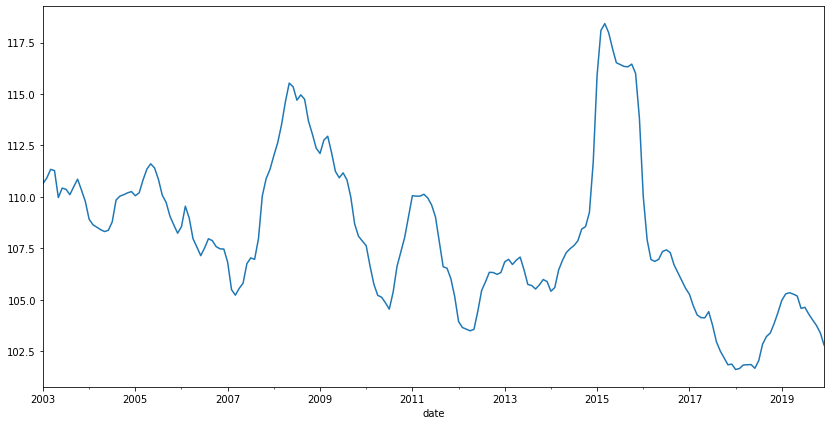

In [500]:
df.t.plot(figsize=(14, 7))

In [501]:
data = df
data_not = data.drop('t', axis=1)
train = data[data.index < train_do]
test = data[data.index >= train_do]

"""
X_train = train.values
y_train = train[['t']].values.ravel()
X_test = test.values
y_test = test[['t']].values.ravel()
"""
X_train = train.drop(['t'], axis=1).values
y_train = train[['t']].values.ravel()
X_test = test.drop(['t'], axis=1).values
y_test = test[['t']].values.ravel()


In [502]:
result['y_test']=pd.DataFrame(np.array(y_test), index = test.index, columns=['y_test'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.34880,104.34880,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,104.46474,104.46474,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,104.61046,104.61046,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,104.47044,104.47044,104.47044,104.47044,103.275185


# **KNeighborsRegressor**

In [503]:
!pip install mglearn -q

In [504]:
from sklearn.datasets import make_blobs
import mglearn
from sklearn.neighbors import KNeighborsRegressor

# instantiate the model 
KNmodel = KNeighborsRegressor(n_neighbors=20)
# fit the model using the training data and training targets
KNmodel.fit(X_train, y_train)

print("Training set score: {:.2f}".format(KNmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNmodel.score(X_test, y_test)))

forecast = KNmodel.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.78
Test set score: -0.49
rmse: 0.5627
normed rmse: 0.5437%


In [505]:
result['KNR']=pd.DataFrame(np.array(forecast), index = test.index, columns=['KNR'])

In [506]:
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.34880,104.34880,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,104.46474,104.46474,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,104.61046,104.61046,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,104.47044,104.47044,104.47044,104.47044,103.275185


# **OLS**

In [507]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

forecast = lr.predict(X_test)
print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.88
rmse: 0.1614
normed rmse: 0.1559%


In [508]:
result['OLS']=pd.DataFrame(np.array(forecast), index = test.index, columns=['OLS'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.34880,104.34880,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,104.46474,104.46474,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,104.61046,104.61046,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,104.47044,104.47044,104.47044,104.47044,103.275185


# **Ridge (l2-regularisation)**

In [509]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

forecast = ridge.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.89
rmse: 0.15
normed rmse: 0.15%


In [510]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.91
rmse: 0.14
normed rmse: 0.13%


In [511]:
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, y_test)))

forecast = ridge10.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.88
rmse: 0.14
normed rmse: 0.13%


In [512]:
result['Ridge']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Ridge'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.34880,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,104.46474,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,104.61046,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,104.47044,104.47044,104.47044,103.275185


# **Lasso (l1-regularisation)**

In [513]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

forecast = lasso.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.96
Test set score: -0.33
Number of features used: 2
rmse: 0.53
normed rmse: 0.51%


In [514]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

forecast = lasso001.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.92
Number of features used: 15
rmse: 0.13
normed rmse: 0.12%


In [515]:
result['Lasso']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Lasso'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.109171,104.34880,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,103.773248,104.46474,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,103.402773,104.61046,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,103.042146,104.47044,104.47044,103.275185


# **ElasticNet (l1+l2-regularisation)**

In [516]:
from sklearn.linear_model import ElasticNet
ENmodel = ElasticNet(alpha=0.01, max_iter=100000, random_state=0)
ENmodel.fit(X_train, y_train)
print("Training set score: {:.2f}".format(ENmodel.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ENmodel.score(X_test, y_test)))
print("Number of features used:", np.sum(ENmodel.coef_ != 0))

forecast = ENmodel.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Training set score: 0.98
Test set score: 0.90
Number of features used: 16
rmse: 0.14
normed rmse: 0.14%


In [517]:
result['ElasticNet']=pd.DataFrame(np.array(forecast), index = test.index, columns=['ElasticNet'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.109171,104.138573,104.34880,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,103.773248,103.799524,104.46474,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,103.402773,103.421190,104.61046,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,103.042146,103.061429,104.47044,103.275185


# **DecisionTree**

In [518]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

forecast = tree.predict(X_test)
print('rmse: {:.2f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.2f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / np.mean(y_test) * 100))

Accuracy on training set: 0.880
Accuracy on test set: -0.256
rmse: 0.52
normed rmse: 0.50%


In [519]:
result['DecisionTree']=pd.DataFrame(np.array(forecast), index = test.index, columns=['DecisionTree'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting
date,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.109171,104.138573,103.730465,103.962608
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,103.773248,103.799524,103.730465,103.702499
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,103.402773,103.421190,103.730465,103.524132
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,103.042146,103.061429,103.730465,103.275185


# **Random Forest**

rmse: 0.692
normed rmse: 0.669%
Accuracy on training set: 0.994
Accuracy on test set: -1.260


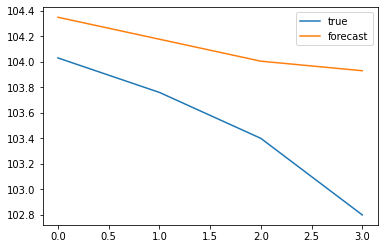

In [520]:
from sklearn.ensemble import RandomForestRegressor

RFmodel = RandomForestRegressor(n_estimators=500, random_state=42)
RFmodel.fit(X_train, y_train)
forecast = RFmodel.predict(X_test)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.3f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.3f}%'.format(mean_squared_error(y_test, forecast) ** 0.5 / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(RFmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RFmodel.score(X_test, y_test)))

In [521]:
result['Random Forest']=pd.DataFrame(np.array(forecast), index = test.index, columns=['Random Forest'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting,Random Forest
date,,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.109171,104.138573,103.730465,103.962608,104.34880
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,103.773248,103.799524,103.730465,103.702499,104.17668
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,103.402773,103.421190,103.730465,103.524132,104.00458
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,103.042146,103.061429,103.730465,103.275185,103.92982


In [522]:
RFmodel.feature_importances_

array([0.00230652, 0.90047864, 0.00402418, 0.00272478, 0.00158503,
       0.00370711, 0.00141798, 0.00132441, 0.00166198, 0.00206096,
       0.05023568, 0.00309605, 0.0017834 , 0.00504464, 0.00294569,
       0.0097369 , 0.00586606])

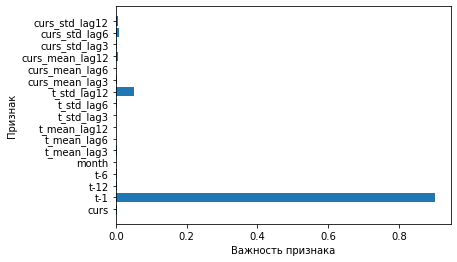

In [523]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(RFmodel)

# **Кроссвалидация**

In [524]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RFmodel, X_train, y_train, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.9217788  0.92075654 0.75152027]
Average cross-validation score: 0.86


In [525]:
from sklearn.model_selection import cross_validate
res = cross_validate(RFmodel, X_train, y_train, cv=4,
                     return_train_score=True)
display(res)

{'fit_time': array([0.97794867, 0.96189761, 0.95771933, 0.9732604 ]),
 'score_time': array([0.02893925, 0.02988911, 0.03194833, 0.02783275]),
 'test_score': array([0.8299524 , 0.88578689, 0.90967553, 0.78106075]),
 'train_score': array([0.99429206, 0.99103277, 0.99562446, 0.99244868])}

In [526]:
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.977949,0.028939,0.829952,0.994292
1,0.961898,0.029889,0.885787,0.991033
2,0.957719,0.031948,0.909676,0.995624
3,0.973260,0.027833,0.781061,0.992449


Mean times and scores:
 fit_time       0.967707
score_time     0.029652
test_score     0.851619
train_score    0.993349
dtype: float64


# **Slide test**

In [527]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
#startdate = pd.to_datetime(data_do)
startdate = pd.to_datetime(train_do)+ relativedelta(months=1)

#print('Today: ', startdate.strftime('%Y-%m-%d'))
#print(date_after_month.strftime('%Y-%m-%d'))
#startdate = str(startdate)[:10]
startdate

Timestamp('2019-10-01 00:00:00')

rmse: 1.1016
normed rmse: 1.0643%


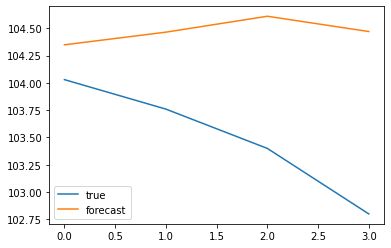

In [528]:
#forecast = RFmodel.predict(X_test)
#slide_test = test[test.index == train_do][data_not.columns.values].values
#print(slide_test)
slide_test = X_test
forecast = []
forecast.append(RFmodel.predict(slide_test)[0])

for i in range(test.shape[0] - 1):
  
  slide_test_next = slide_test.copy()
  slide_test_next[0, 1] = forecast[-1]

  slide_test_next[0, 0] += 1
  slide_test_next[0, 2:] = slide_test[0, 1:-1]
  
  #print(slide_test_next)
  slide_test = slide_test_next.copy()

  forecast.append(RFmodel.predict(slide_test)[0])

forecast = np.array(forecast)

plt.plot(y_test, label='true')
plt.plot(forecast, label='forecast')
plt.legend()

print('rmse: {:.4f}'.format(mean_squared_error(y_test, forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, forecast) ** 0.5) / np.mean(y_test) * 100))


# **KFold cross validation**

In [529]:
#!pip install mglearn -q
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import mglearn


In [530]:
%%time
model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)
#model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.66064318  0.77811502  0.76410182  0.66582613 -0.05091977]
CPU times: user 464 ms, sys: 2.65 ms, total: 466 ms
Wall time: 472 ms


In [531]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.56


# **Stratified K-Fold cross-validation and other strategies**

In [532]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3)

In [533]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.91484025 0.90880947 0.7480308 ]


In [534]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
print("Cross-validation scores:\n{}".format(
    cross_val_score(model, X_train, y_train, cv=kfold)))

Cross-validation scores:
[0.96061363 0.91844659 0.94978761]


# **GradientBoostingRegressor**

In [535]:
from xgboost import XGBRegressor

[09:41:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 0.2495
normed rmse: 0.2411%
Accuracy on training set: 1.000
Accuracy on test set: 0.706


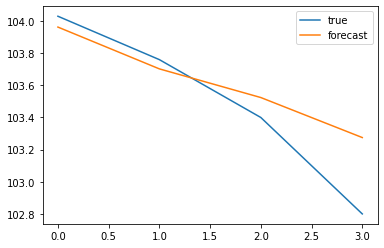

In [536]:
xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_train, y_train)], verbose=False)
# make predictions
xgb_forecast = xgb_model.predict(X_test)
xgb_model.feature_importances_
plt.plot(y_test, label='true')
plt.plot(xgb_forecast, label='forecast')
plt.legend()

from sklearn.metrics import mean_squared_error
print('rmse: {:.4f}'.format(mean_squared_error(y_test, xgb_forecast) ** 0.5))
print('normed rmse: {:.4f}%'.format((mean_squared_error(y_test, xgb_forecast) ** 0.5) / 
                                    np.mean(y_test) * 100))

print("Accuracy on training set: {:.3f}".format(xgb_model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_model.score(X_test, y_test)))

In [537]:
result['GradientBoosting']=pd.DataFrame(np.array(xgb_forecast), index = test.index, columns=['GradientBoosting'])
result

,y_test,KNR,OLS,ARIMAX,ARIMA,Ridge,Lasso,ElasticNet,DecisionTree,GradientBoosting,Random Forest
date,,,,,,,,,,,
2019-09-01,104.03,103.9835,104.172201,103.940585,103.912674,104.120471,104.109171,104.138573,103.730465,103.962608,104.34880
2019-10-01,103.76,103.8690,103.754614,103.768827,103.727756,103.790413,103.773248,103.799524,103.730465,103.702499,104.17668
2019-11-01,103.40,103.9370,103.388603,103.688968,103.641722,103.404762,103.402773,103.421190,103.730465,103.524132,104.00458
2019-12-01,102.80,103.7820,103.089428,103.651838,103.596516,103.055849,103.042146,103.061429,103.730465,103.275185,103.92982


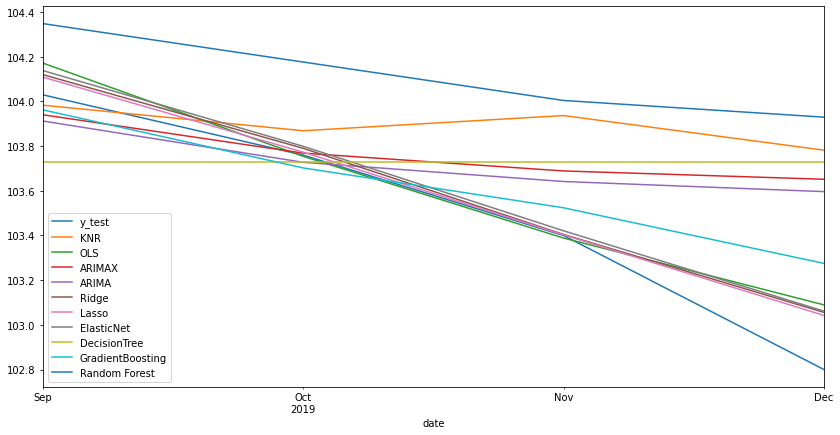

In [538]:
result.plot(figsize=(14, 7))

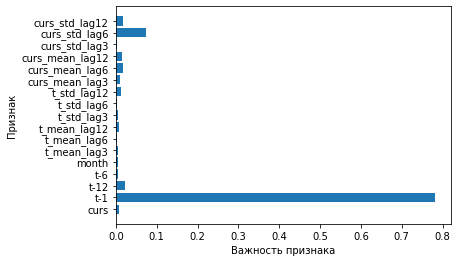

In [539]:
def plot_features(model):
  n_features = data_not.shape[1]
  plt.barh(range(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), data_not.columns)
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
plot_features(xgb_model)